In [1]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm
import re
import pdb

In [2]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.57', '1.1.0')

In [3]:
torch.cuda.set_device(0)

In [4]:
path = Path('/home/gaurav/PycharmProjects/nlp-for-panjabi/classification')

In [5]:
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,article,is_about_politics
0,ਮਾਇਆਵਤੀ ਅਤੇ ਮੁਲਾਇਮ ਸਿੰਘ ਯਾਦਵ ਨੂੰ ਦੁਸ਼ਮਣ ਬਣਾਉਣ...,True
1,ਇਸ ਤੇਲਗੂ ਫਿਲਮ ਅਦਾਕਾਰਾ ਨੇ ਕਿਉਂ ਲਾਹੇ ਸੜਕ 'ਤੇ ਕੱ...,False
2,ਵੈਸਟਮਿਨਸਟਰ ਕਾਰ ਹਾਦਸਾ: ਸ਼ੱਕੀ ਅੱਤਵਾਦੀ ਵਾਰਦਾਤ ਦੇ...,False
3,ਪਾਕਿਸਤਾਨ ਵਿੱਚ ਇਸਰਾਈਲ ਦੇ ਜਹਾਜ਼ ਨੇ ਇੰਝ ਮੱਚਾਈ ‘ਤ...,False
4,ਮਨਦੀਪ ਸਿੰਘ ਇਸ ਵੇਲੇ ਇਟਲੀ ਰਹਿ ਰਹੇ ਹਨ। ਬੀਬੀਸੀ ਪੰ...,False


In [6]:
valid_df = pd.read_csv(path/'valid.csv')
valid_df.head()

,article,is_about_politics
0,"ਹਾਈ ਹੀਲ ਦੀ ਜੁੱਤੀ ਕਦੋਂ, ਕਿੱਥੇ ਅਤੇ ਕਿਵੇਂ ਆਈ ਪ੍ਰ...",False
1,ਸੁਖਬੀਰ ਬਾਦਲ: ਮੈਂ ਅਕਸ਼ੇ ਨੂੰ ਕਦੇ ਪੰਜਾਬ ਤੋਂ ਬਾਹਰ...,True
2,ਨਰਿੰਦਰ ਮੋਦੀ ਦੀ ਨਵੀਂ ਨਰਮੀ ਪਿੱਛੇ ਰਾਹੁਲ ਗਾਂਧੀ ਦਾ...,True
3,ਖਿਡਾਰੀਆਂ 'ਚ ਲੋਕ ਭਲਾਈ ਦਾ ਐਨਾ ਜੋਸ਼ ਕਿਉਂ ਹੈ ਬਿ...,False
4,ਕੇਂਦਰੀ ਦਿੱਲੀ ਵਿੱਚ ਆਂਧਰਾ ਭਵਨ ਦੇ ਬਾਹਰ ਗਿਟਾਰ ਰਾਓ...,False


In [7]:
print('In Training data:')
for cls in train_df['is_about_politics'].unique():
    print(cls, (train_df['is_about_politics'] == cls).sum())

In Training data:
True 88
False 539


In [8]:
print('In Validation data:')
for cls in valid_df['is_about_politics'].unique():
    print(cls, (valid_df['is_about_politics'] == cls).sum())

In Validation data:
False 131
True 26


In [9]:
train_df['article'][0]

' ਮਾਇਆਵਤੀ ਅਤੇ ਮੁਲਾਇਮ ਸਿੰਘ ਯਾਦਵ ਨੂੰ ਦੁਸ਼ਮਣ ਬਣਾਉਣ ਵਾਲਾ ਗੈਸਟ ਹਾਊਸ ਕਾਂਡ  ਭਰਤ ਸ਼ਰਮਾ ਬੀਬੀਸੀ ਪੱਤਰਕਾਰ       13 ਜਨਵਰੀ 2019                                              ਈਮੇਲ                                                 ਸਾਂਝਾ ਕਰੋ                                                 ਈਮੇਲ  ਈਮੇਲ    ਲਿੰਕ ਨੂੰ ਕਾਪੀ ਕਰੋ  https://www.bbc.com/punjabi/india-46850353  ਸਾਂਝਾ ਕਰਨ ਬਾਰੇ ਹੋਰ ਪੜ੍ਹੋ   ਸਾਂਝਾ ਕਰਨ ਵਾਲੇ ਪੈਨਲ ਨੂੰ ਬੰਦ ਕਰੋ              Image copyright Getty Images  ਉੱਤਰ ਪ੍ਰਦੇਸ਼ ਦੀ ਰਾਜਧਾਨੀ ਲਖਨਊ ਵਿੱਚ ਬਹੁਜਨ ਸਮਾਜ ਪਾਰਟੀ ਅਤੇ ਅਤੇ ਸਮਾਜਵਾਦੀ ਪਾਰਟੀ ਨੇ ਸਮਝੌਤੇ ਦਾ ਐਲਾਨ ਕੀਤਾ। ਬਸਪਾ ਦੀ ਸੁਪਰੀਮੋ ਮਾਇਆਵਤੀ ਅਤੇ ਸਪਾ ਮੁਖੀ ਅਖਿਲੇਸ਼ ਯਾਦਵ ਨੇ ਦੱਸਿਆ ਕਿ ਇਹ ਸਿਰਫ 2019 ਦੀਆਂ ਲੋਕ ਸਭਾ ਚੋਣਾਂ ਲਈ ਨਹੀਂ ਹੈ ਸਗੋਂ ਲੰਬੇ ਸਮੇਂ ਤੱਕ ਚੱਲੇਗਾ।ਦੋਹਾਂ ਧਿਰਾਂ ਨੇ ਕਿਹਾ ਕਿ ਉਹ ਲੋਕ ਸਭਾ ਚੋਣਾਂ ਵਿੱਚ ਸੂਬੇ ਦੀਆਂ 38-38 ਸੀਟਾਂ \'ਤੇ ਚੋਣ ਲੜਨਗੀਆਂ। ਰਾਇਬਰੇਲੀ ਅਤੇ ਅਮੇਠੀ ਸੀਟ ਕਾਂਗਰਸ ਲਈ ਛੱਡ ਦਿੱਤੀ ਗਈ ਹੈ ਅਤੇ ਬਾਕੀ ਦੋ ਸੀਟਾਂ ਸਹਿਯੋਗੀਆਂ ਲਈ ਛੱਡ ਦਿੱਤੀਆਂ ਗਈਆਂ ਹਨ।ਪ੍ਰੈਸ ਕਾਨਫਰੰਸ ਨੂੰ ਸੰਬੋਧਨ ਕਰਦਿਆਂ ਮਾਇਆਵਤੀ ਗੈਸਟ ਹਾਊਸ ਕਾਂਡ ਦਾ ਜ਼ਿਕਰ ਕਰਨਾ ਨਹੀਂ ਭੁੱਲੇ ਅਤੇ ਉਨ੍ਹਾਂ ਕਿਹਾ ਕਿ ਦਹਿਸ਼ਤ ਅਤੇ ਜਨਹਿਤ ਵਿੱਚ ਉਨ੍ਹਾਂ ਨੇ ਇਸ ਗਠਬ

In [10]:
train_df.shape

(627, 2)

In [11]:
train_df[train_df['article'].isnull()].shape, valid_df[valid_df['article'].isnull()].shape

((0, 2), (0, 2))

In [12]:
label_cols = list(range(1,train_df.shape[1]))

In [13]:
print(label_cols)

[1]


In [14]:
id_to_col = list(train_df.columns)

In [15]:
col_to_id = {}
for i, col in enumerate(id_to_col):
    col_to_id[col] = i

In [16]:
class PanjabiTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str('../tokenizer/panjabi_lm.model'))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [17]:
sp = spm.SentencePieceProcessor()
sp.Load('../tokenizer/panjabi_lm.model')
itos = [sp.IdToPiece(int(i)) for i in range(30000)]

In [18]:
# 30,000 is the vocab size that we chose in sentencepiece
panjabi_vocab = Vocab(itos)

In [19]:
panjabi_tok = PanjabiTokenizer('pb')

In [20]:
tokenizer = Tokenizer(tok_func=PanjabiTokenizer, lang='pb')

In [21]:
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [22]:
data_lm = TextLMDataBunch.from_df(path=path, train_df=train_df, valid_df=valid_df, text_cols=[0], label_cols=label_cols, tokenizer=tokenizer, vocab=panjabi_vocab, bs=16)

In [23]:
data_lm.save()

In [24]:
data_lm.show_batch()

idx,text
0,▁ਕਰੋ <unk> ▁i m age ▁co py right <unk> ▁g et ty <unk> ▁i m age s ▁ਉੱਤਰ ▁ਪ੍ਰਦੇਸ਼ ▁ਦੀ ▁ਰਾਜਧਾਨੀ ▁ਲਖਨਊ ▁ਵਿੱਚ ▁ਬਹੁਜਨ ▁ਸਮਾਜ ▁ਪਾਰਟੀ ▁ਅਤੇ ▁ਅਤੇ ▁ਸਮਾਜਵਾਦੀ ▁ਪਾਰਟੀ ▁ਨੇ ▁ਸਮਝੌਤੇ ▁ਦਾ ▁ਐਲਾਨ ▁ਕੀਤਾ । ▁ਬਸ ਪਾ ▁ਦੀ ▁ਸੁਪਰੀ ਮੋ ▁ਮਾਇਆ ਵਤੀ ▁ਅਤੇ ▁ਸਪਾ ▁ਮੁਖੀ ▁ਅਖਿਲ ੇਸ਼ ▁ਯਾਦਵ ▁ਨੇ ▁ਦੱਸਿਆ ▁ਕਿ ▁ਇਹ ▁ਸਿਰਫ ▁ 2019 ▁ਦੀਆਂ ▁ਲੋਕ ▁ਸਭਾ ▁ਚੋਣਾਂ ▁ਲਈ ▁ਨਹੀਂ ▁ਹੈ ▁ਸਗੋਂ ▁ਲੰਬੇ ▁ਸਮੇਂ ▁ਤੱਕ ▁ਚੱਲ ੇਗਾ ।
1,"ਵਿਰੋਧੀ ' ▁ਮੰਨਿਆ ▁ਜਾਂਦਾ ▁ਹੈ । ▁ਮੀਡੀਆ ▁ਪਲੇਬੈਕ ▁ਤੁਹਾਡੀ ▁ਡਿਵਾਈਸ ▁' ਤੇ ▁ਸਪੋਰਟ ▁ਨਹੀਂ ▁ਕਰਦਾ ▁ਕਸ਼ਮੀਰ ▁ਵਿੱਚ ▁ਭਾਜਪਾ ▁ਵਰਕਰ ▁ਹੋਣਾ ▁ਕਿੰਨਾ ▁ਮੁਸ਼ਕਿਲ ਬਾਬ ਰੀ ▁ਮਸਜਿਦ , ▁ਧਾਰਾ ▁3 70 ▁ਅਤੇ ▁35 ▁ਏ ▁ਵਰਗੇ ▁ਮੁੱਦਿਆਂ ▁' ਤੇ ▁ਭਾਜਪਾ ▁ਦੇ ▁ਸਟੈਂਡ ▁ਕਾਰਨ ▁ਪਾਰਟੀ ▁ਨਾਲ ▁ਜੁੜੇ ▁ਹੋਏ ▁ਦਿਖਣ ਾ ▁ਸੌਖਾ ▁ਨਹੀਂ ▁ਹੈ । ▁ਪਾਰਟੀ ▁ਦੇ ▁ਮੁਤਾਬਕ ▁ਘਾਟੀ ▁ਵਿੱਚ ▁ਉਸਦੇ ▁500 ▁ਦੇ ▁ਕਰੀਬ ▁' ਐਕਟਿਵ ' ▁ਵਰਕਰ ▁ਹਨ । ▁ਇੱਕ ▁ਭਾਜਪਾ ▁ਲੀਡਰ ▁ਮੁਤਾਬਕ ▁1996"
2,▁ਔਰਤ ▁ਹੁਣ ▁ਭਾਰਤ ▁ਲਈ ▁ਮਨੁੱਖ ▁ਪੁਲਾੜ ▁ਭੇਜੇ ਗੀ ▁ਇਮਰਾਨ ▁ਕੁਰੈਸ਼ੀ ▁ਬੀਬੀਸੀ ▁ਲਈ ▁15 ▁ਅਗਸਤ ▁2018 ▁ਈਮੇਲ ▁ਸਾਂਝਾ ▁ਕਰੋ ▁ਈਮੇਲ ▁ਈਮੇਲ ▁ਲਿੰਕ ▁ਨੂੰ ▁ਕਾਪੀ ▁ਕਰੋ ▁http s : ▁/ ▁/ ▁w ww . bb c . com ▁/ ▁ punjabi ▁/ ▁ india - 45 18 1906 ▁ਸਾਂਝਾ ▁ਕਰਨ ▁ਬਾਰੇ ▁ਹੋਰ ▁ਪੜ੍ਹ ੋ ▁ਸਾਂਝਾ ▁ਕਰਨ ▁ਵਾਲੇ ▁ਪੈਨਲ ▁ਨੂੰ ▁ਬੰਦ ▁ਕਰੋ <unk> ▁i m age ▁co py right <unk> ▁i m ran
3,▁ਲਈ ▁ਮਹਿੰਗੇ ▁ਤੋਹਫ ਿਆਂ ▁ਬਾਰੇ ▁ਸਰਕਾਰ ▁ਨੂੰ ▁1 ▁ਮਹੀਨੇ ▁ਦੇ ▁ਅੰਦਰ - ਅੰਦਰ ▁ਦੱਸਣਾ ▁ਲ ਾਜ਼ਮੀ ▁ਬਣਾ ▁ਦਿੱਤਾ ▁ਹੈ । ਅ ਖ਼ ਬਾਰ ▁ਮੁਤਾਬਕ ▁ਹਾਲ ▁ਹੀ ▁ਵਿਚ ▁ਮੁਹਾਲੀ ▁ਵਿੱਚ ▁ਇਕ ▁ਐਸ ਐਚ ਓ ▁ਨੂੰ ▁ਕਿਸੇ ▁ਪ੍ਰਾ ਪਰ ਟੀ ▁ਡੀ ਲਰ ▁ਕੋਲੋਂ ▁ਮਿਲੀ ▁ਰੇਂਜ ▁ਰੋ ਵਰ ▁ਵਿੱਚ ▁ਨਾ ਕੇ ▁' ਤੇ ▁ਡਿਊਟੀ ▁ਦਿੰਦਿਆਂ ▁ਦੇਖਿਆ ▁ਗਿਆ ▁ਸੀ । ▁ਅਜਿਹੇ ▁ਹੋਰ ▁ਵੀ ▁ਮਾਮਲੇ ▁ਸਾਹਮਣੇ ▁ਆਉਂਦੇ ▁ਰਹਿੰਦੇ ▁ਹਨ । ਇਹ ▁ਵੀ ▁ਪੜ੍ਹ ੋ :
4,"▁ਵੀ ▁ਜਾਣਕਾਰੀ ▁ਦਿੱਤੀ ▁ਜਾ ▁ਰਹੀ ▁ਹੈ ▁ਕਿ ▁ਇਹ ▁ਕਮੇਟੀ ▁ਪੁਰਾਤਤਵ ਿਕ , ▁ਪ੍ਰਾਚੀਨ ▁ਪਾਂਡੂ ਲਿਪ ੀਆਂ ▁ਅਤੇ ▁ਡੀ ਐੱਨ ਏ ▁ਦੇ ▁ਆਧਾਰ ▁' ਤੇ ▁ਇਹ ▁ਸਾਬਿਤ ▁ਕਰਨ ▁ਦੀ ▁ਕੋਸ਼ਿਸ਼ ▁ਕਰੇਗੀ ▁ਕਿ ▁ਮੌਜੂਦਾ ▁ਹਿੰਦੂ ▁ਹੀ ▁ਦੇ ਸ ▁' ਚ ▁ਹਜ਼ਾਰਾਂ ▁ਸਾਲ ▁ਪਹਿਲਾਂ ▁ਆਬਾਦ ▁ਹੋਣ ▁ਵਾਲੇ ▁ਲੋਕਾਂ ▁ਦੀਆਂ ▁ਨਸਲਾਂ ▁ਹਨ । ਇਤਿਹਾਸ ਕਾਰਾਂ ▁ਦੀ ▁ਇਹ ▁ਕਮੇਟੀ ▁ਇਹ ▁ਵੀ ▁ਸਾਬਿਤ ▁ਕਰੇਗੀ ▁ਕਿ ▁ਹਿੰਦੂਆਂ ▁ਦੀਆਂ ▁ਪ੍ਰਾਚੀਨ ▁ਧਾਰਮਿਕ ▁ਕਿਤਾਬਾਂ ▁ਸਿਰਫ ▁ਕਹਾਣੀਆਂ ▁ਨਹੀਂ ▁ਇਤਿਹਾਸਕ ▁ਹਕੀਕਤ ▁ਹਨ"


In [29]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3, pretrained=False)

In [30]:
# Loading the pretrained language model on panjabi wikipedia
learn.load(path/'../language-model/ulmfit/models/model', with_opt=True)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (627 items)
x: LMTextList
▁x x bo s ▁ਮਾਇਆ ਵਤੀ ▁ਅਤੇ ▁ਮੁਲਾਇਮ ▁ਸਿੰਘ ▁ਯਾਦਵ ▁ਨੂੰ ▁ਦੁਸ਼ਮਣ ▁ਬਣਾਉਣ ▁ਵਾਲਾ ▁ਗੈਸ ਟ ▁ਹਾਊਸ ▁ਕਾਂਡ ▁ਭਰਤ ▁ਸ਼ਰਮਾ ▁ਬੀਬੀਸੀ ▁ਪੱਤਰਕਾਰ ▁13 ▁ਜਨਵਰੀ ▁ 2019 ▁ਈਮੇਲ ▁ਸਾਂਝਾ ▁ਕਰੋ ▁ਈਮੇਲ ▁ਈਮੇਲ ▁ਲਿੰਕ ▁ਨੂੰ ▁ਕਾਪੀ ▁ਕਰੋ ▁http s : ▁/ ▁/ ▁w ww . bb c . com ▁/ ▁ punjabi ▁/ ▁ india - 46 850 35 3 ▁ਸਾਂਝਾ ▁ਕਰਨ ▁ਬਾਰੇ ▁ਹੋਰ ▁ਪੜ੍ਹ ੋ ▁ਸਾਂਝਾ ▁ਕਰਨ ▁ਵਾਲੇ ▁ਪੈਨਲ ▁ਨੂੰ ▁ਬੰਦ ▁ਕਰੋ <unk> ▁i m age ▁co py right <unk> ▁g et ty <unk> ▁i m age s ▁ਉੱਤਰ ▁ਪ੍ਰਦੇਸ਼ ▁ਦੀ ▁ਰਾਜਧਾਨੀ ▁ਲਖਨਊ ▁ਵਿੱਚ ▁ਬਹੁਜਨ ▁ਸਮਾਜ ▁ਪਾਰਟੀ ▁ਅਤੇ ▁ਅਤੇ ▁ਸਮਾਜਵਾਦੀ ▁ਪਾਰਟੀ ▁ਨੇ ▁ਸਮਝੌਤੇ ▁ਦਾ ▁ਐਲਾਨ ▁ਕੀਤਾ । ▁ਬਸ ਪਾ ▁ਦੀ ▁ਸੁਪਰੀ ਮੋ ▁ਮਾਇਆ ਵਤੀ ▁ਅਤੇ ▁ਸਪਾ ▁ਮੁਖੀ ▁ਅਖਿਲ ੇਸ਼ ▁ਯਾਦਵ ▁ਨੇ ▁ਦੱਸਿਆ ▁ਕਿ ▁ਇਹ ▁ਸਿਰਫ ▁ 2019 ▁ਦੀਆਂ ▁ਲੋਕ ▁ਸਭਾ ▁ਚੋਣਾਂ ▁ਲਈ ▁ਨਹੀਂ ▁ਹੈ ▁ਸਗੋਂ ▁ਲੰਬੇ ▁ਸਮੇਂ ▁ਤੱਕ ▁ਚੱਲ ੇਗਾ । ਦੋਹ ਾਂ ▁ਧਿਰਾਂ ▁ਨੇ ▁ਕਿਹਾ ▁ਕਿ ▁ਉਹ ▁ਲੋਕ ▁ਸਭਾ ▁ਚੋਣਾਂ ▁ਵਿੱਚ ▁ਸੂਬੇ ▁ਦੀਆਂ ▁38 - 38 ▁ਸੀਟਾਂ ▁' ਤੇ ▁ਚੋਣ ▁ਲੜਨ ਗੀਆਂ । ▁ਰਾਇ ਬਰੇ ਲੀ ▁ਅਤੇ ▁ਅਮ ੇ ਠੀ ▁ਸੀਟ ▁ਕਾਂਗਰਸ ▁ਲਈ ▁ਛੱਡ ▁ਦਿੱਤੀ ▁ਗਈ ▁ਹੈ ▁ਅਤੇ ▁ਬਾਕੀ ▁ਦੋ ▁ਸੀਟਾਂ ▁ਸਹਿਯੋਗੀ ਆਂ ▁ਲਈ ▁ਛੱਡ ▁ਦਿੱਤੀਆਂ ▁ਗਈਆਂ ▁ਹਨ । ਪ੍ਰੈਸ ▁ਕਾਨ

In [31]:
# Fine tuning the prtrained LM on current dataset

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


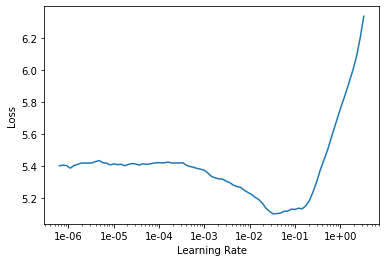

In [33]:
learn.recorder.plot()

In [34]:
learn.freeze()

In [35]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.186049,4.241057,0.340724,00:48


In [36]:
learn.unfreeze()

In [37]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.689218,4.062803,0.361080,00:54
1,3.405905,3.956107,0.376402,00:56
2,3.091360,3.960693,0.379968,00:55


In [38]:
learn.predict('ਜੋ ਉਹਨਾਂ ਦੇ ਰੱਬਾਂ ਨੂੰ ਪ੍ਰਸਤੁਤ ਕਰਦੇ',n_words=10)

'ਜੋ ਉਹਨਾਂ ਦੇ ਰੱਬਾਂ ਨੂੰ ਪ੍ਰਸਤੁਤ ਕਰਦੇ ▁ਹਨ ▁ਇਸ ੀ ਚਲ ਨ ▁ਪੂਰੀ ▁ਦੁਨੀਆਂ ▁ਵਿੱਚ ▁ਸਭ ▁ਤੋਂ'

In [39]:
learn.save_encoder('fine_tuned_enc')

In [40]:
data_clas = TextClasDataBunch.from_df(path=path, train_df=train_df, valid_df=valid_df, tokenizer=tokenizer, vocab=panjabi_vocab, text_cols=[0], label_cols=label_cols, bs=16)

In [43]:
data_clas.show_batch()

text,target
"▁x x bo s ▁ਉੱਤਰੀ ▁ਕੋਰੀਆ ▁ਤੋਂ ▁ਭੱਜ ੀਆਂ , ▁ਚੀਨ ▁' ਚ ▁ਸੈਕਸ ▁ਸਕ ੈਂਡ ਲ ▁' ਚ ▁ਫਸ ੀਆਂ ▁ਕੁੜੀਆਂ ▁ਕਿਵੇਂ ▁ਬਚ ▁ਨਿਕਲ ੀਆਂ ▁? ▁ਸੁ - ਮਿਨ ▁ਵੈ ਂਗ ▁ਪੱਤਰਕਾਰ , ▁ਬੀਬੀਸੀ ▁21 ▁ਜਨਵਰੀ ▁ 2019 ▁ਈਮੇਲ ▁ਸਾਂਝਾ ▁ਕਰੋ ▁ਈਮੇਲ ▁ਈਮੇਲ ▁ਲਿੰਕ ▁ਨੂੰ ▁ਕਾਪੀ ▁ਕਰੋ ▁http s : ▁/ ▁/ ▁w ww . bb c . com ▁/ ▁ punjabi ▁/ ▁in tern ational - 46 93",False
"▁x x bo s ▁ਕਿਸਾਨਾਂ ▁ਦੀਆਂ ▁ਖੁਦਕੁਸ਼ੀ ਆਂ ▁ਤੇਲੰਗਾਨਾ ▁' ਚ ▁ਰੁਕ ▁ਸਕਦੀਆਂ ▁ਤਾਂ ▁ਪੰਜਾਬ ▁' ਚ ▁ਕਿਉਂ ▁ਨਹੀਂ ▁: <unk> ▁b b c <unk> ▁s p e c i <unk> al ▁ਪ੍ਰਿ ਅੰਕ ਾ ▁ਦੂ ਬੇ ▁ਬੀਬੀਸੀ ▁ਪੱਤਰਕਾਰ , ▁ਤੇਲੰਗਾਨਾ ▁ਤੋਂ ▁ਵਾਪਸ ▁ਆ ▁ਕੇ ▁3 ▁ਸਤੰਬਰ ▁2018 ▁ਈਮੇਲ ▁ਸਾਂਝਾ ▁ਕਰੋ ▁ਈਮੇਲ ▁ਈਮੇਲ ▁ਲਿੰਕ ▁ਨੂੰ ▁ਕਾਪੀ ▁ਕਰੋ ▁http s : ▁/ ▁/ ▁w ww . bb c . com ▁/",False
▁x x bo s ▁ਦਿ ▁ਐਕਸੀਡੈਂਟ ਲ ▁ਪ੍ਰਾਈਮ ▁ਮਿਨਿਸਟਰ : ▁ ਮਨਮੋਹਨ ▁ਸਿੰਘ ▁ਦੇ ▁ਸਲਾਹਕਾਰ ▁ਨੇ ▁ਅਸਲ ▁' ਚ ▁ਉਨ੍ਹਾਂ ▁ਤੇ ▁ਸੋਨੀਆ ▁ਗਾਂਧੀ ▁ਬਾਰੇ ▁ਆਪਣੀ ▁ਕਿਤਾਬ ▁' ਚ ▁ਕੀ ▁ਲਿਖਿਆ ▁ਰੇ ਹਾਨ ▁ਫ਼ਜ਼ਲ ▁ਬੀਬੀਸੀ ▁ਪੱਤਰਕਾਰ ▁8 ▁ਜਨਵਰੀ ▁ 2019 ▁ਈਮੇਲ ▁ਸਾਂਝਾ ▁ਕਰੋ ▁ਈਮੇਲ ▁ਈਮੇਲ ▁ਲਿੰਕ ▁ਨੂੰ ▁ਕਾਪੀ ▁ਕਰੋ ▁http s : ▁/ ▁/ ▁w ww . bb c . com ▁/ ▁ punjabi ▁/ ▁ india -4 67 86 362,False
"▁x x bo s ▁ਬੁਲੰਦ ਸ਼ਹਿਰ ▁ਹਿੰਸਾ : ▁ਕੀ ▁ਪੁਲਿਸ ▁’ ਤੇ ▁ਹੈ ▁ਯੋਗ ੀ ▁ਸਰਕਾਰ ▁ਦਾ ▁ਦਬਾਅ ? ▁ਪੜ੍ਹ ੋ ▁ਗਰਾਊਂਡ ▁ਰਿਪੋਰਟ ▁ਨਿਤ ਿਨ ▁ਸ਼੍ਰੀਵਾਸਤਵ ▁ਬੀਬੀਸੀ ▁ਪੱਤਰਕਾਰ , ▁ਬੁਲੰਦ ਸ਼ਹਿਰ ▁ਤੋਂ ▁21 ▁ਦਸੰਬਰ ▁2018 ▁ਈਮੇਲ ▁ਸਾਂਝਾ ▁ਕਰੋ ▁ਈਮੇਲ ▁ਈਮੇਲ ▁ਲਿੰਕ ▁ਨੂੰ ▁ਕਾਪੀ ▁ਕਰੋ ▁http s : ▁/ ▁/ ▁w ww . bb c . com ▁/ ▁ punjabi ▁/ ▁ india -4 66 40 6 11 ▁ਸਾਂਝਾ ▁ਕਰਨ ▁ਬਾਰੇ",False
"▁x x bo s ▁1984 ▁ਦਿੱਲੀ ▁ਸਿੱਖ ▁ਕਤਲੇਆਮ ▁ਜਾਂ ▁ਗੁਜਰਾਤ ▁ਵਰਗਾ ▁ਕਾਂਡ ▁ਦੁਬਾਰਾ ▁ਨਹੀਂ ▁ਵਾਪਰੇ ਗਾ , ▁ਕੀ ▁ਅਸੀਂ ▁ਇਹ ▁ਕਹਿ ▁ਸਕਦੇ ▁ਹਾਂ ▁- ▁ਨਜ਼ਰੀਆ ▁ਸ਼ਮੀ ਲ ▁ਸੀਨੀਅਰ ▁ਪੱਤਰਕਾਰ ▁14 ▁ਜਨਵਰੀ ▁ 2019 ▁ਈਮੇਲ ▁ਸਾਂਝਾ ▁ਕਰੋ ▁ਈਮੇਲ ▁ਈਮੇਲ ▁ਲਿੰਕ ▁ਨੂੰ ▁ਕਾਪੀ ▁ਕਰੋ ▁http s : ▁/ ▁/ ▁w ww . bb c . com ▁/ ▁ punjabi ▁/ ▁ india - 46 82 97 91 ▁ਸਾਂਝਾ ▁ਕਰਨ ▁ਬਾਰੇ ▁ਹੋਰ ▁ਪੜ੍ਹ",False


In [44]:
valid_labels = []
for item in data_clas.valid_ds:
    valid_labels.append(item[1])

In [45]:
counter = defaultdict(int)
for label in valid_labels:
    counter[label.data] = counter[label.data] + 1
counter

defaultdict(int, {0: 131, 1: 26})

In [46]:
print('Percentage false in validation data: ', counter[0]/(counter[0]+counter[1]))
print('Percentage true in validation data: ', counter[1]/(counter[0]+counter[1]))

Percentage false in validation data:  0.8343949044585988
Percentage true in validation data:  0.16560509554140126


In [56]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5)

In [57]:
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (627 items)
x: TextList
▁x x bo s ▁ਮਾਇਆ ਵਤੀ ▁ਅਤੇ ▁ਮੁਲਾਇਮ ▁ਸਿੰਘ ▁ਯਾਦਵ ▁ਨੂੰ ▁ਦੁਸ਼ਮਣ ▁ਬਣਾਉਣ ▁ਵਾਲਾ ▁ਗੈਸ ਟ ▁ਹਾਊਸ ▁ਕਾਂਡ ▁ਭਰਤ ▁ਸ਼ਰਮਾ ▁ਬੀਬੀਸੀ ▁ਪੱਤਰਕਾਰ ▁13 ▁ਜਨਵਰੀ ▁ 2019 ▁ਈਮੇਲ ▁ਸਾਂਝਾ ▁ਕਰੋ ▁ਈਮੇਲ ▁ਈਮੇਲ ▁ਲਿੰਕ ▁ਨੂੰ ▁ਕਾਪੀ ▁ਕਰੋ ▁http s : ▁/ ▁/ ▁w ww . bb c . com ▁/ ▁ punjabi ▁/ ▁ india - 46 850 35 3 ▁ਸਾਂਝਾ ▁ਕਰਨ ▁ਬਾਰੇ ▁ਹੋਰ ▁ਪੜ੍ਹ ੋ ▁ਸਾਂਝਾ ▁ਕਰਨ ▁ਵਾਲੇ ▁ਪੈਨਲ ▁ਨੂੰ ▁ਬੰਦ ▁ਕਰੋ <unk> ▁i m age ▁co py right <unk> ▁g et ty <unk> ▁i m age s ▁ਉੱਤਰ ▁ਪ੍ਰਦੇਸ਼ ▁ਦੀ ▁ਰਾਜਧਾਨੀ ▁ਲਖਨਊ ▁ਵਿੱਚ ▁ਬਹੁਜਨ ▁ਸਮਾਜ ▁ਪਾਰਟੀ ▁ਅਤੇ ▁ਅਤੇ ▁ਸਮਾਜਵਾਦੀ ▁ਪਾਰਟੀ ▁ਨੇ ▁ਸਮਝੌਤੇ ▁ਦਾ ▁ਐਲਾਨ ▁ਕੀਤਾ । ▁ਬਸ ਪਾ ▁ਦੀ ▁ਸੁਪਰੀ ਮੋ ▁ਮਾਇਆ ਵਤੀ ▁ਅਤੇ ▁ਸਪਾ ▁ਮੁਖੀ ▁ਅਖਿਲ ੇਸ਼ ▁ਯਾਦਵ ▁ਨੇ ▁ਦੱਸਿਆ ▁ਕਿ ▁ਇਹ ▁ਸਿਰਫ ▁ 2019 ▁ਦੀਆਂ ▁ਲੋਕ ▁ਸਭਾ ▁ਚੋਣਾਂ ▁ਲਈ ▁ਨਹੀਂ ▁ਹੈ ▁ਸਗੋਂ ▁ਲੰਬੇ ▁ਸਮੇਂ ▁ਤੱਕ ▁ਚੱਲ ੇਗਾ । ਦੋਹ ਾਂ ▁ਧਿਰਾਂ ▁ਨੇ ▁ਕਿਹਾ ▁ਕਿ ▁ਉਹ ▁ਲੋਕ ▁ਸਭਾ ▁ਚੋਣਾਂ ▁ਵਿੱਚ ▁ਸੂਬੇ ▁ਦੀਆਂ ▁38 - 38 ▁ਸੀਟਾਂ ▁' ਤੇ ▁ਚੋਣ ▁ਲੜਨ ਗੀਆਂ । ▁ਰਾਇ ਬਰੇ ਲੀ ▁ਅਤੇ ▁ਅਮ ੇ ਠੀ ▁ਸੀਟ ▁ਕਾਂਗਰਸ ▁ਲਈ ▁ਛੱਡ ▁ਦਿੱਤੀ ▁ਗਈ ▁ਹੈ ▁ਅਤੇ ▁ਬਾਕੀ ▁ਦੋ ▁ਸੀਟਾਂ ▁ਸਹਿਯੋਗੀ ਆਂ ▁ਲਈ ▁ਛੱਡ ▁ਦਿੱਤੀਆਂ ▁ਗਈਆਂ ▁ਹਨ । ਪ੍ਰੈਸ ▁ਕਾਨਫਰੰਸ 

In [58]:
learn.freeze()

In [59]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


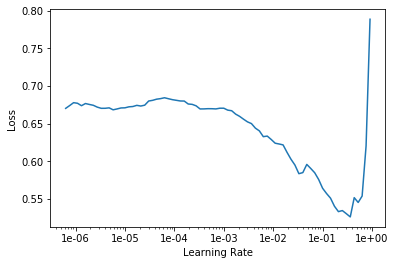

In [60]:
learn.recorder.plot()

In [61]:
learn.loss_func.func

CrossEntropyLoss()

In [62]:
kappa = KappaScore()

In [63]:
learn.metrics = [accuracy, kappa]

In [64]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.380908,0.362023,0.847134,0.122088,00:31


In [ ]:
# 84% is the accuracy which we can get by just outputting all 0s

In [65]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.269441,0.382938,0.840764,0.148036,00:37


In [66]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='final')])

epoch,train_loss,valid_loss,accuracy,kappa_score,time
0,0.218885,0.387565,0.853503,0.281679,00:52
1,0.198084,0.378416,0.853503,0.250363,00:47
2,0.162040,0.340036,0.891720,0.545083,00:48
3,0.130571,0.353980,0.866242,0.438043,00:54
4,0.111179,0.369602,0.866242,0.438043,00:56


Better model found at epoch 0 with accuracy value: 0.8535031676292419.
Better model found at epoch 2 with accuracy value: 0.8917197585105896.


In [ ]:
# Todos: Clean the input text a little